In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import os
import numpy as np

2024-05-08 18:44:47.594725: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-08 18:44:47.594808: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-08 18:44:47.741565: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
EPOCHS = 50
CHANNELS = 3

# 1. Getting Images

`tf.keras.preprocessing.image_dataset_from_directory` is a utility function in TensorFlow's Keras module that creates an image dataset from a directory of images. This function is useful for training models using images stored in a directory structure.

Here's a breakdown of its purpose and how it works:

1. **Input Directory**: It expects images organized in a directory structure, where each subdirectory represents a class. The images within each subdirectory belong to that particular class.

   ```python
   root_directory/
       class1/
           img1.jpg
           img2.jpg
           ...
       class2/
           img1.jpg
           img2.jpg
           ...
   ```

2. **Output Dataset**: The function outputs a `tf.data.Dataset` object containing pairs of (image, label), where:
   - **Image**: Tensor of shape `(height, width, channels)`.
   - **Label**: Integer representing the class index.

3. **Parameters**:
   - `directory`: Path to the root directory where the class subdirectories are stored.
   - `labels`: 'inferred' (default) assumes the subdirectory names are class names; otherwise, pass a list or tuple of class labels.
   - `label_mode`: 'int', 'categorical', 'binary', or `None` to specify how to represent labels.
   - `batch_size`: Size of the batches of data.
   - `image_size`: Desired size for all images, which will be resized if necessary.
   - `shuffle`: Whether to shuffle the data.
   - `validation_split`: Ratio for splitting data into training and validation.
   - `subset`: If using `validation_split`, specify 'training' or 'validation'.
   - `seed`: Random seed for reproducibility.

### Example Usage
```python
from tensorflow.keras.preprocessing import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
    'path/to/root_directory',
    labels='inferred',
    label_mode='int',
    batch_size=32,
    image_size=(224, 224),
    shuffle=True,
    validation_split=0.2,
    subset='training',
    seed=123
)

validation_dataset = image_dataset_from_directory(
    'path/to/root_directory',
    labels='inferred',
    label_mode='int',
    batch_size=32,
    image_size=(224, 224),
    shuffle=True,
    validation_split=0.2,
    subset='validation',
    seed=123
)
```

This function simplifies image data loading and is commonly used for preparing and getting data from a list of directories for training machine learning models.

In [3]:
base_dir = '/kaggle/input/plant-village/PlantVillage'
new_dir = '/kaggle/output/plant-village/SelectedFolders'

# Create a new directory for the selected folders
if not os.path.exists(new_dir):
    os.makedirs(new_dir)

# List of folder names you want to include
selected_folders = ["Potato___Early_blight", "Potato___Late_blight", "Potato___healthy"]

# Create symbolic links
for folder in selected_folders:
    source = os.path.join(base_dir, folder)
    link = os.path.join(new_dir, folder)
    if not os.path.exists(link):
        os.symlink(source, link)

# Create the dataset using the new directory with symbolic links
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    new_dir,
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [4]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [5]:
len(dataset)

68

The `68` here refers to the number of batches. Since, we have chose `32` batches, so by `68*32` we get the `2176` data. 

In [6]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())
    
    print("\nTensor of first image: \n", image_batch[0][1][:2])         # This is a tensor of the first image in the batch
    print("\nNumpy of first image: \n", image_batch[0][1][:2].numpy())  # This is the numpy array of the first image in the batch

(32, 256, 256, 3)
[1 1 0 1 1 1 1 0 1 0 1 2 0 0 0 1 1 0 0 0 0 1 1 1 1 2 0 1 1 0 1 0]

Tensor of first image: 
 tf.Tensor(
[[148. 145. 152.]
 [148. 145. 152.]], shape=(2, 3), dtype=float32)

Numpy of first image: 
 [[148. 145. 152.]
 [148. 145. 152.]]


`32` images of dimension `256 * 256` with three channels. In the numpy array, the `0`, `1`, and `2` are the classes of dataset. 

Now, let's use these codes to show an image:

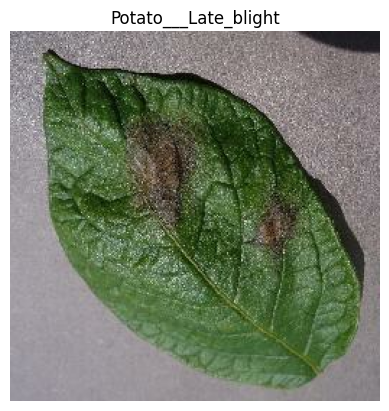

In [7]:
plt.imshow(image_batch[0].numpy().astype("uint8"))  # We convert it to int8 because the image is in float32
plt.axis("off")
plt.title(class_names[labels_batch[0]])
plt.show()

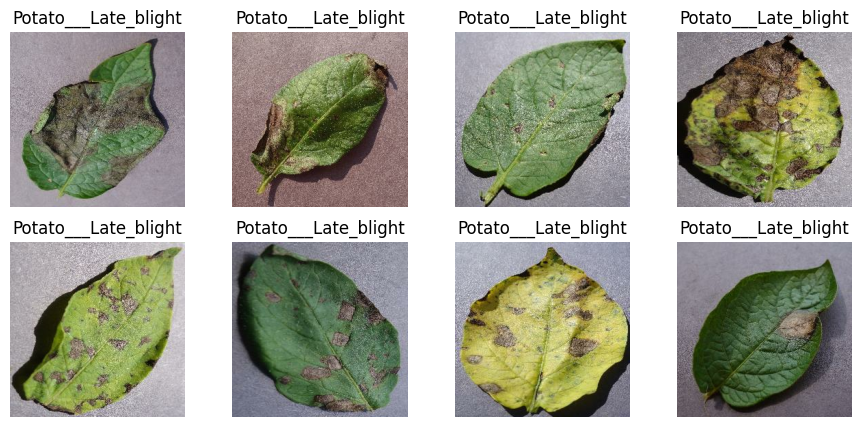

In [8]:
plt.figure(figsize=(11, 5))
for image_batch, labels_batch in dataset.take(1):
    for i in range(8):
        ax = plt.subplot(2, 4, i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))  # We convert it to int8 because the image is in float32
        plt.axis("off")
        plt.title(class_names[labels_batch[0]])

# 2. Data Splitting
For this project, we will consider 80% of the data for the training, and 10% for each test and Validation data. This equals to `54` datapoint for training and `6` datapoints for validation data and `8` for test data.

In [9]:
def split_dataset(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + val_split + test_split) == 1
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
        
    train_size = int(train_split * len(ds))
    val_size = int(val_split * len(ds))
    
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds


train_ds, val_ds, test_ds = split_dataset(dataset)
len(train_ds), len(val_ds), len(test_ds)

(54, 6, 8)

In the following line:

1. **`cache()`**: This method caches the dataset in memory after it is first read. If the dataset is too large to fit in memory, you can specify a file path to cache it on disk instead. This helps speed up training as the data does not need to be reloaded and transformed multiple times.

2. **`shuffle(1000)`**: This method shuffles the dataset in a random order. The `1000` parameter specifies the size of the buffer used for shuffling. A larger buffer size will provide a better randomized shuffling, but requires more memory. In this case, 1000 samples will be held in the buffer for random selection.

3. **`prefetch()`**: This method enables the dataset to fetch batches ahead of time in a background thread while the model is training on the current batch. This helps reduce the time between batches and ensures that the data is readily available when required.

Overall, the combination of these functions helps improve data throughput and performance in training by caching, shuffling, and prefetching data efficiently.

In [10]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

In [11]:
SCALE_FACTOR = 1./255

resize_and_rescale = tf.keras.Sequential([
    tf.keras.layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),  # Resizing layer
    tf.keras.layers.Rescaling(SCALE_FACTOR)            # Rescaling layer
])

Data augmentation is a technique commonly used in machine learning and computer vision tasks, including image classification. It involves applying various transformations to the existing dataset to create new, slightly modified versions of the original images.

Here are some reasons why data augmentation is beneficial in this context:

1. **Increased Dataset Size**: Data augmentation allows us to artificially increase the size of our dataset by generating new samples. This is particularly useful when working with limited amounts of labeled data, as it helps prevent overfitting and improves the generalization ability of the model.

2. **Improved Model Robustness**: By applying random transformations to the images, data augmentation helps the model become more robust to variations in the input data. It exposes the model to a wider range of variations, such as rotations, translations, flips, and changes in brightness or contrast, making it more capable of handling real-world scenarios.

3. **Reduced Overfitting**: Overfitting occurs when a model becomes too specialized in learning the training data and fails to generalize well to unseen data. Data augmentation introduces diversity into the training set, making it harder for the model to memorize specific patterns or features. This regularization effect helps reduce overfitting and improves the model's ability to generalize to new, unseen images.

4. **Improved Model Performance**: Data augmentation can lead to improved model performance by providing more diverse and representative samples for training. It helps the model learn more robust and discriminative features, leading to better classification accuracy and overall performance.

Overall, data augmentation is a powerful technique that enhances the performance and generalization ability of machine learning models, especially in scenarios where the available labeled data is limited.

In [12]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),  # Randomly flip horizontally and vertically
    tf.keras.layers.RandomRotation(0.2),  # Rotate images by up to 20%
    tf.keras.layers.RandomZoom(0.1)  # Zoom images by up to 10%
])


# Model Building

In [13]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = len(class_names)

model = models.Sequential([
    resize_and_rescale,  
    data_augmentation,
    
    # Convolutional layers
    layers.Conv2D(32, (3, 3), padding="same", activation="relu", input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), padding="same", activation="relu"),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), padding="same", activation="relu"),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), padding="same", activation="relu", input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), padding="same", activation="relu"),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), padding="same", activation="relu"),
    layers.MaxPooling2D((2, 2)),

    # Dense layers
    layers.Flatten(),
    layers.Dense(64, activation="relu"),
    layers.Dense(n_classes, activation="softmax")
])

model.build(input_shape=input_shape)
print(model.summary())

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (32, 256, 256, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (32, 128, 128, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (32, 128, 128, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (32, 64, 64, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (32, 64, 64, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (32, 32, 32, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (32, 32, 32, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (32, 16, 16, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (32, 16, 16, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (32, 8, 8, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (32, 8, 8, 64)         │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (32, 4, 4, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (32, 1024)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (32, 64)               │        65,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (32, 3)                │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 232,899 (909.76 KB)

 Trainable params: 232,899 (909.76 KB)

 Non-trainable params: 0 (0.00 B)

None


In [14]:
model.compile(
    optimizer="adam", 
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), 
    metrics=["accuracy"]
    )

In [15]:
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,    
    validation_data=val_ds,

)

Epoch 1/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 15s 81ms/step - accuracy: 0.4484 - loss: 0.9516 - val_accuracy: 0.6823 - val_loss: 0.8700
Epoch 2/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 0.7352 - loss: 0.7198 - val_accuracy: 0.7917 - val_loss: 0.5992
Epoch 3/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 0.8226 - loss: 0.5027 - val_accuracy: 0.8594 - val_loss: 0.4530
Epoch 4/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 0.8770 - loss: 0.3830 - val_accuracy: 0.5208 - val_loss: 0.9970
Epoch 5/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 0.8629 - loss: 0.3547 - val_accuracy: 0.8281 - val_loss: 0.4467
Epoch 6/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 0.8953 - loss: 0.2673 - val_accuracy: 0.9115 - val_loss: 0.2593
Epoch 7/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 0.8843 - loss: 0.2791 - val_accuracy: 0.8750 - val_loss: 0.3159
Epoch 8/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 0.9303 - loss: 0.1865 - val_accuracy: 0.9271 - 

Checking the score for the test set:

In [16]:
scores = model.evaluate(test_ds)
scores

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.8918 - loss: 0.3809


[0.4547007381916046, 0.8828125]

an awsome accuracy :))

Let's plot them:

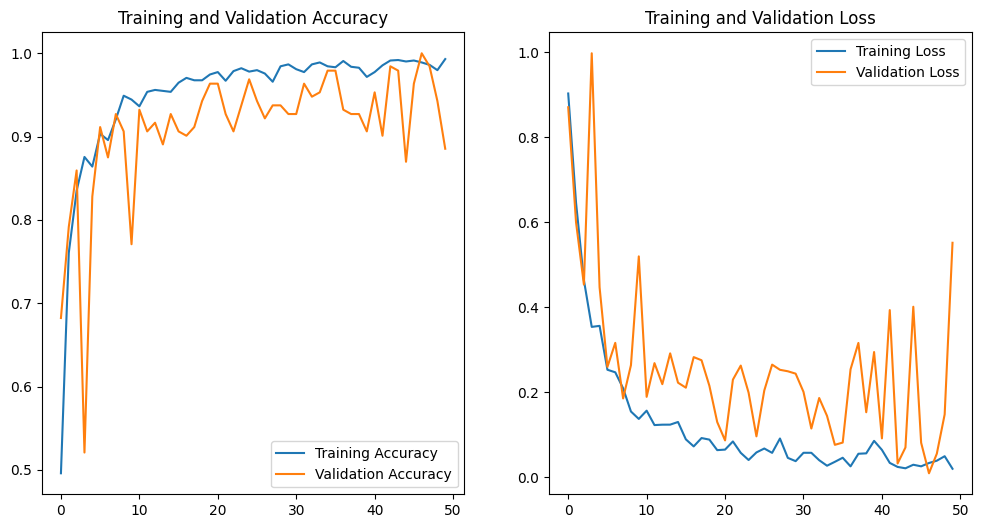

In [17]:
# Extract the history data
acc = history.history['accuracy']  # Replace 'accuracy' with 'acc' if you face a key error
val_acc = history.history['val_accuracy']  # Replace 'val_accuracy' with 'val_acc' if you face a key error
loss = history.history['loss']
val_loss = history.history['val_loss']

# Set the number of epochs to the length of the accuracy history
epochs_range = range(len(acc))

# Plot training and validation accuracy
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()


In [18]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)
    
    predictions = model.predict(img_array)
    
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


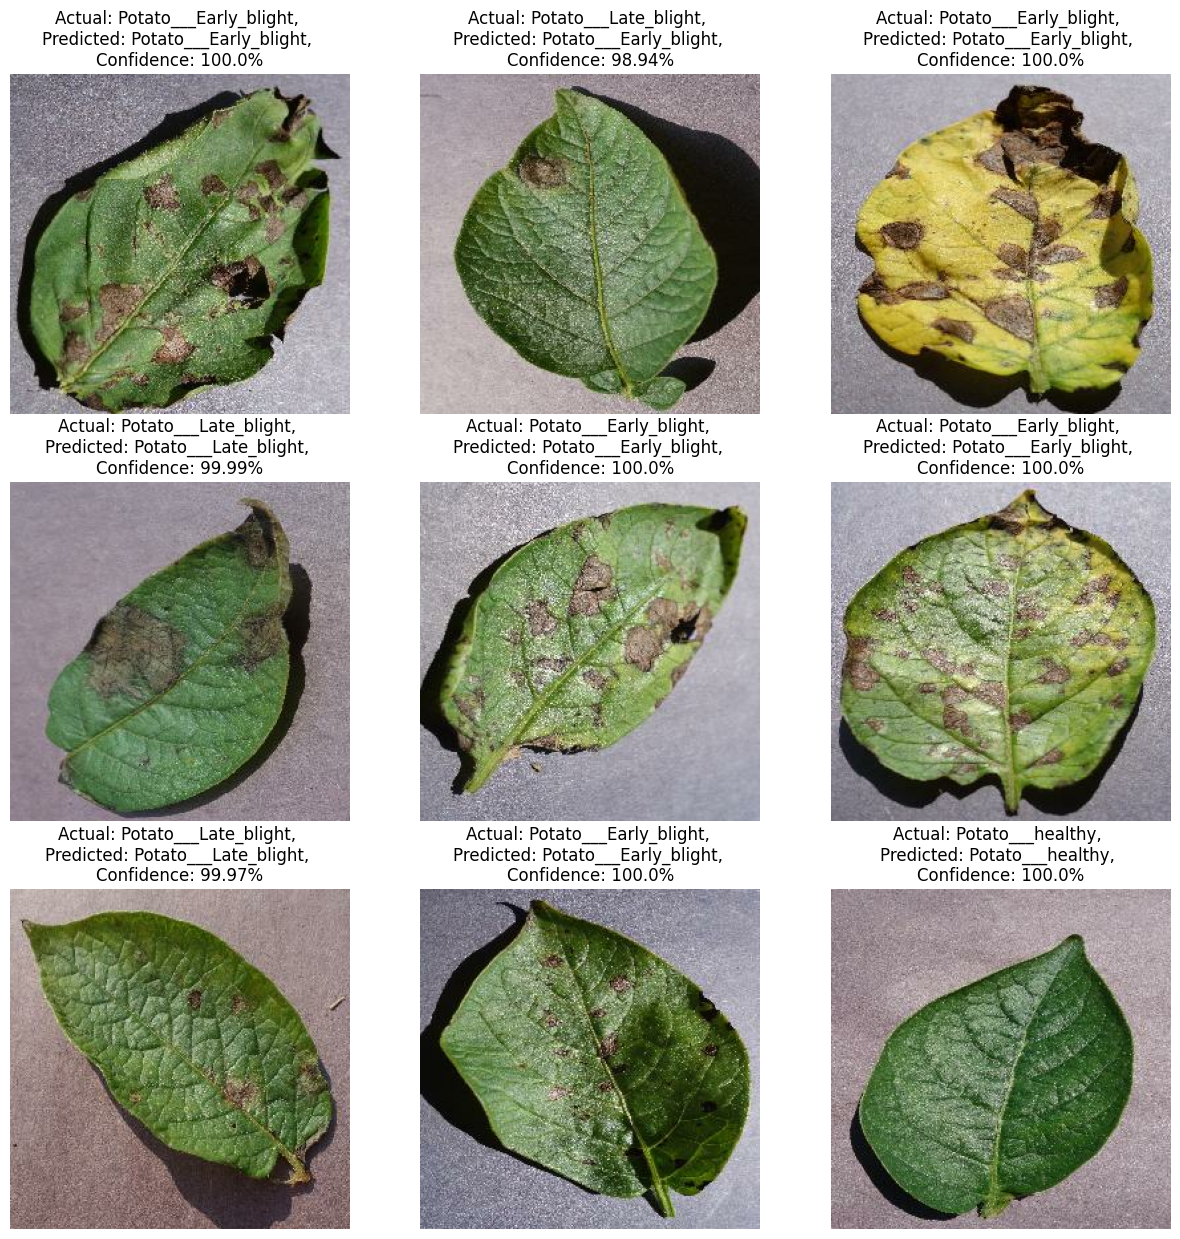

In [19]:
plt.figure(figsize=(15, 15))

for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]
        
        plt.title(f"Actual: {actual_class}, \nPredicted: {predicted_class}, \nConfidence: {confidence}%")
        plt.axis("off")
        

In [20]:
model_version = 1
model.save(f'/kaggle/working/Model_v{model_version}.keras')